## <center>GANs - Generative Adverserial Networks</center>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist

import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Flatten
from tensorflow.keras.models import Sequential

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

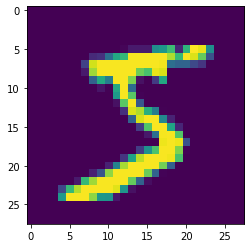

In [3]:
plt.imshow(X_train[0])

#### Filtering out the Data for Faster Training on Smaller Dataset

In [4]:
only_zeros = X_train[y_train==0]
only_zeros.shape

(5923, 28, 28)

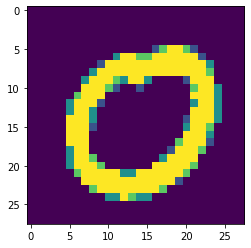

In [5]:
plt.imshow(only_zeros[950])

### Building the Generator and Discriminator

In [6]:
discriminator = Sequential()
discriminator.add(Flatten())
discriminator.add(Dense(150,activation='relu'))
discriminator.add(Dense(100,activation='relu'))

# Fianl output layer --> it's always binary discrimination FAKE or REAL
discriminator.add(Dense(1,activation="sigmoid"))

discriminator.compile(loss="binary_crossentropy", optimizer="adam")

For the case of the generator, it is important to mention, that it looks very similar to a decoder from the AutoEncoders lecture, so, it will start with a certain coding size and build up to the 1D size of the inputed images. The size of the codings size should be less form the total features, but not that small, that the generator can´t learn.

In [7]:
codings_size = 100


generator = Sequential()
generator.add(Dense(100, # The number of neurons can be the same as the codings size however is not a rule
                    activation="relu", 
                    input_shape=[codings_size])) 
generator.add(Dense(150,activation='relu'))
generator.add(Dense(784, activation="sigmoid")) # 28*28 = 784
generator.add(Reshape([28,28]))

In [8]:
GAN = Sequential([generator, discriminator])

In [9]:
discriminator.trainable = False # Set to False to allow the GAN to compile
GAN.compile(loss="binary_crossentropy", optimizer="adam")

In [10]:
GAN.layers

In [11]:
GAN.layers[0].summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 150)               15150     
                                                                 
 dense_5 (Dense)             (None, 784)               118384    
                                                                 
 reshape (Reshape)           (None, 28, 28)            0         
                                                                 
Total params: 143,634
Trainable params: 143,634
Non-trainable params: 0
_________________________________________________________________


In [12]:
GAN.layers[1].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 150)               117750    
                                                                 
 dense_1 (Dense)             (None, 100)               15100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 132,951
Trainable params: 0
Non-trainable params: 132,951
_________________________________________________________________


### Setting up Training Batches

In [13]:
batch_size = 32

In [14]:
my_data = only_zeros
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)

https://stackoverflow.com/questions/46444018/meaning-of-buffer-size-in-dataset-map-dataset-prefetch-and-dataset-shuffle

The buffer_size in Dataset.shuffle() can affect the randomness of your dataset, and hence the order in which elements are produced. Also it limits the amount of data loaded.

In [15]:
type(dataset)

tensorflow.python.data.ops.dataset_ops.ShuffleDataset

In [16]:
dataset = dataset.batch(
    batch_size, 
    drop_remainder=True # In this case, if the values remaining are less than a batch, they are dropped
).prefetch(1)

epochs = 1

**NOTE: The generator never actually sees any real images. It learns by viewing the gradients going back through the discriminator. The better the discrimnator gets through training, the more information the discriminator contains in its gradients, which means the generator can being to make progress in learning how to generate fake images, in our case, fake zeros.**

### Training Loop

In [17]:
# Grab the seprate components
generator, discriminator = GAN.layers

# For every epcoh
for epoch in range(epochs):
    print(f"Currently on Epoch {epoch+1}")
    i = 0

    # For every batch in the dataset
    for X_batch in dataset:
        i += 1
        if i%100 == 0:
            print(f"\tCurrently on batch number {i} of {len(my_data)//batch_size}")


        #####################################
        ## TRAINING THE DISCRIMINATOR ######
        ###################################

        # STEPS:
        
        # 1. Create Noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # 2. Generate numbers based just on noise input --> generator never sees the actual images, only sees noise
        gen_images = generator(noise)
        
        # 3. Concatenate Generated Images against the Real Ones
        # TO use tf.concat, the data types must match!
        X_fake_vs_real = tf.concat(
            [
                gen_images, 
                tf.dtypes.cast(X_batch,tf.float32)
            ], axis=0
        )
        
        # 4. Targets set to zero for fake images and 1 for real images
        y1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
        
        # 5. Make the discriminator trainable
        discriminator.trainable = True
        
        # 6. Train the discriminator on this batch
        discriminator.train_on_batch(X_fake_vs_real, y1)
        
        
        #####################################
        ## TRAINING THE GENERATOR     ######
        ###################################

        # STEPS:
        
        # 1. Create some noise
        noise = tf.random.normal(shape=[batch_size, codings_size])
        
        # 2. We want discriminator to belive that fake images are real
        y2 = tf.constant([[1.0]] * batch_size)
        
        # 3. Enable the GAN to be trained, in this case the generator is trained through the GAN
        discriminator.trainable = False
        
        GAN.train_on_batch(noise, y2)
        
print("TRAINING COMPLETE")            

Currently on Epoch 1
	Currently on batch number 100 of 185
TRAINING COMPLETE


### Testing the model

In [18]:
noise = tf.random.normal(shape=[10, codings_size])
noise.shape

TensorShape([10, 100])

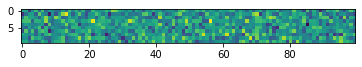

In [19]:
plt.imshow(noise)

In [20]:
image = generator(noise)
image.shape

TensorShape([10, 28, 28])

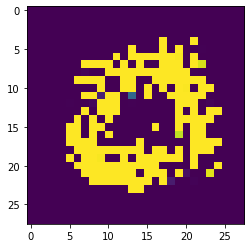

In [21]:
plt.imshow(image[2])

Most likely your generator will only learn to create one type of noisey zero. Regardless of what noise is passed in.

https://www.quora.com/What-does-it-mean-if-all-produced-images-of-a-GAN-look-the-same